# Ocular Image Disease Detection
This project is handling image based data involving the human eye. These images are taken through a method called fundus photography, where an optomotrist is able to take an image of the inside of the human eyeball. The primary objective is to use this dataset to make classifications of ocular disease and impairments. This image dataset also comes along with a csv file that holds the diagnosis of each image that will allow for a machine learning model to be trained and tested. To analyze these images an ensemble model of two Convolutional Neural Networks will be used.

## Data Scrubbing
There is a total of 8,000 images within the Training Image directory, each of which must have its resolution normalized and centered, to obtain optimal predictions. This is a challenge since the collection of images all have unique resolutions and setting a defining term for standardization can be a hassle. There are also images within the file that can be considered blurred or dirty that must be removed; each image must also be trimmed to eliminate black space to minimize runtime and the need for fewer CNN layers. After this processing is done, the images must be divided into their respective classifications for training. There is a csv file that holds each image's diagnosis that must also be maintained with the scrubbing. The images each have a unique ID number at the beginning of each image file name that ends with a '_left.jpg' or _right.jpg' and this will allow for left and right eye analysis. The right eye image can be flipped to avoid having to create a seperate CNN model without having a negative impact.

In [1]:
# Packges
import numpy as np
import os # File Navigation for Directory
import cv2 # OpenCV
import imghdr # Handles image directories
import copy # Copying images
from matplotlib import pyplot as plt

# This is where the image data is held.
img_dir = "C:\\Users\\David\\GCU\\Capstone_Project\\Milestone3\\Webpage\\Images\\ODIR-5K_Playground"

Here is a peak at the images that are being analyzed. From first look it is clear that some trimming will be beneifical for the model. Below features the image in its actual color, but by default the jpg is displayed in black and white. This is because Opencv by default analyzes images as binary to increase reading speed, and allow for easier trimming

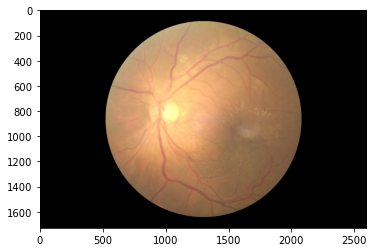

In [20]:
# This features the image in its actual color, but by default the jpg is displayed in black and white.
testimage = 'C:\\Users\\David\\GCU\\Capstone_Project\\Milestone3\\Webpage\\Images\\ODIR-5K\\training_images\\6_left.jpg'
jpg = cv2.imread(testimage)
plt.imshow(cv2.cvtColor(jpg, cv2.COLOR_BGR2RGB))

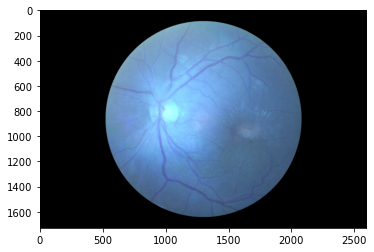

In [21]:
plt.imshow(jpg)

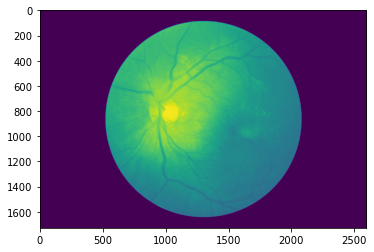

In [22]:
# Here is a negative viewing of the image
njpg = cv2.imread(testimage,0)
plt.imshow(njpg)

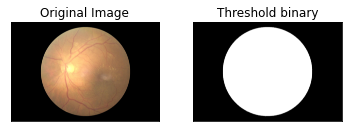

In [23]:
def Cropper(img_path):
    original = cv2.imread(img_path)

    # Read the image, convert it into grayscale, and make in binary image for threshold value of 1.
    img = cv2.imread(img_path,0)

    # use binary threshold, all pixel that are beyond 3 are made white
    img, thresh_original = cv2.threshold(img, 3, 255, cv2.THRESH_BINARY) # Thresh_binary is the type

    # Now find contours in it.
    thresh = copy.copy(thresh_original)
    contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

    # get contours with highest height
    lst_contours = []
    for cnt in contours:
        crop = cv2.boundingRect(cnt)
        lst_contours.append(crop)
    x,y,w,h = sorted(lst_contours, key=lambda coef: coef[3])[-1]
    crop = copy.copy(original)
    
    return(crop,x,y,w,h)

test,x,y,w,h = Cropper(testimage)

# Original
plt.subplot(221), plt.imshow(cv2.cvtColor(jpg, cv2.COLOR_BGR2RGB))
plt.title('Original Image'), plt.xticks([]),plt.yticks([])

# Threshold
njpg, thresh_original = cv2.threshold(njpg, 3, 255, cv2.THRESH_BINARY)
plt.subplot(222), plt.imshow(thresh_original, cmap='gray')
plt.title('Threshold binary'), plt.xticks([]),plt.yticks([])

plt.show()

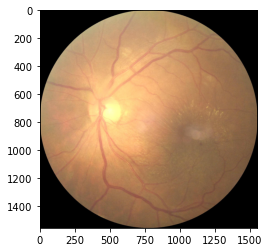

In [24]:
# Final Cropped Image
test = test[:,:,::-1]
test = test[y:y+h, x:x+w]
plt.imshow(test)

All images have now been trimmed into a perfectly square outlight of the eye. This took a while but a major relief to have it done. The image data of all 8,000 records has now been scrubbed. There are still some anomalies, but the model should be able to filter those out. The resolutions of all the images are still vastly different, but this can be handled with the Tensorflow resizing function later on.

In [25]:
'''
extentions = ['jpg','jpeg','png']
count = 0
for img_class in os.listdir(img_dir):
    for images in os.listdir(os.path.join(img_dir,img_class)):
        img_path = os.path.join(img_dir,img_class,images)
            # This has been removed since its task is already complete
            #jpg = cv2.imread(img_path)
            #crop,x,y,w,h = Cropper(img_path)
            #imgcrop = crop[y:y+h, x:x+w]
            #cv2.imwrite(os.path.join(os.path.join(img_dir,img_class),images), imgcrop)
        try: # Removes non jpg and corrupt images
            ext = imghdr.what(img_path) # removes all non image files
            jpg = cv2.imread(img_path) # removes corrupt files
            if ext not in extentions:
                os.remove(img_path)
                print("{} has been removed".format(images))
        except Exception as e:
            os.remove(img_path)
            print("Error has occured with image {}".format(images))
        print(count) # Confirmed 8,000 images starting from 0 to 7999
        count = count + 1
'''

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062


3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702


5142
5143
5144
5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341


6781
6782
6783
6784
6785
6786
6787
6788
6789
6790
6791
6792
6793
6794
6795
6796
6797
6798
6799
6800
6801
6802
6803
6804
6805
6806
6807
6808
6809
6810
6811
6812
6813
6814
6815
6816
6817
6818
6819
6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980


The next step is setting up classifications with this newly scrubbed data to train the model. Using the csv validation dataset, we can move the images into the proper files. There is an issue here though, a significant number of the patients have multiple diagnoses, which complicates how the CNN model classification needs to function. This is the reason why two CNN models are being used, to handle multiple binary classifications on a single image. Also I can't use the entire dataset, since the streamlit application has a limit on data uploads, which the user of the UI will also run into. This is something that needs to be addressed before the UI can be fully functional.

This is the list of classifications within the csv file, following this exact order.

(N) Normal - A Normal Fundus

(D) Diabetes - Symptoms are mild and moderate non profliferative retinopathy

(G) Glaucoma 

(C) Cataract - The image is very blurred.

(A) Age related Macular Degeneration

(H) Hypertension - Hypotensive Retinopathy

(M) Pathological Myopia - Normally affects both eyes

(O) Other diseases/Abnormalities - Individually insignificant in number

In [96]:
# Separating files into classifications

# The csv_dir holds csv files feature specific images of each disease in separate files.
csv_dir = 'C:\\Users\\David\\GCU\\Capstone_Project\\Milestone3\\Webpage\\Images\\image_diagnosis'
images = 'C:\\Users\\David\\GCU\\Capstone_Project\\Milestone3\\Webpage\\Images\\ODIR-5K_Playground\\training_images'
classes = 'C:\\Users\\David\\GCU\\Capstone_Project\\Milestone3\\Webpage\\Images\\Classifications'
train = 'C:\\Users\\David\\GCU\\Capstone_Project\\Milestone3\\Webpage\\validation\\Validation_data.csv'
val = 'C:\\Users\\David\\GCU\\Capstone_Project\\Milestone3\\Webpage\\validation\\full_df_Validation.csv'

In [143]:
import pandas as pd

df = pd.read_csv(train)
df[['Left-Fundus','Left-Diagnostic Keywords']]

,Left-Fundus,Left-Diagnostic Keywords
0,0_left.jpg,cataract
1,1_left.jpg,normal fundus
2,2_left.jpg,laser spot?moderate non proliferative retinopathy
3,3_left.jpg,normal fundus
4,4_left.jpg,macular epiretinal membrane
...,...,...
3495,4686_left.jpg,severe nonproliferative retinopathy
3496,4688_left.jpg,moderate non proliferative retinopathy
3497,4689_left.jpg,mild nonproliferative retinopathy
3498,4690_left.jpg,mild nonproliferative retinopathy


It is seen that patients can have multiple diagnoses, which complicates the composition of the data pipeline. Should the model ignore multi diagnosis or add the image under both categories, which might muddle of the predictive capabilities with overlapping characteristics. For training the model I believe avoiding multiple diagnosis would be best, but when predicting the outcome a multi characteristic outcome might be best.

In [160]:
'''
import shutil

textarray = ['normal fundus','mild non proliferative retinopathy','mild nonproliferative retinopathy',
            'moderate non proliferative retinopathy','moderate nonproliferative retinopathy',
            'severe non proliferative retinopathy','severe nonproliferative retinopathy',
            'proliferative diabetic retinopathy','glaucoma','cataract',
            'wet age-related macular degeneration','dry age-related macular degeneration',
            'hypertensive retinopathy','pathological myopia']

for i in range(len(df)):
    jpg = df.iloc[i,3] # Left eye images
    dis = df.iloc[i,5]
    #jpg = df.iloc[i,4] # Right eye images
    #dis = df.iloc[i,6]
    for img in os.listdir(images):
        img_path = os.path.join(images,img)
        if jpg == img:
            if dis == 'normal fundus':
                path = os.path.join(classes,'Normal') 
                shutil.move(img_path,path)
            elif (
                dis == 'mild non proliferative retinopathy' or
                dis == 'mild nonproliferative retinopathy' or
                dis == 'moderate non proliferative retinopathy' or
                dis == 'moderate nonproliferative retinopathy' or
                dis == 'severe non proliferative retinopathy' or
                dis == 'severe nonproliferative retinopathy' or
                dis == 'proliferative diabetic retinopathy'
            ):
                path = os.path.join(classes,'Diabetes')
                shutil.move(img_path,path)
            elif dis == 'glaucoma':
                path = os.path.join(classes,'Glaucoma')  
                shutil.move(img_path,path)
            elif dis == 'cataract':  
                path = os.path.join(classes,'Cataract')  
                shutil.move(img_path,path)
            elif (
                dis == 'wet age-related macular degeneration' or 
                dis == 'dry age-related macular degeneration'
            ):  
                path = os.path.join(classes,'AMD')
                shutil.move(img_path,path)
            elif dis == 'hypertensive retinopathy':  
                path = os.path.join(classes,'Hypertension')
                shutil.move(img_path,path)
            elif dis == 'pathological myopia':  
                path = os.path.join(classes,'Myopia')
                shutil.move(img_path,path)
            elif all(x not in dis for x in textarray): 
                path = os.path.join(classes,'Abnormal')
                shutil.move(img_path,path)
'''

The right eye images could still be flipped, to try to instill further consistency in the model.

### Uploading Data Pipeline
After filtering through the data, there is a remainder of 6154 image files for training

In [2]:
import tensorflow as tf# To build a data pipeline, with tf.data.Dataset API
import keras 
tf.config.experimental.list_physical_devices('CPU') # CPU is good

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [6]:
tf.test.gpu_device_name() # My GPU is not being connecting... This is a major issue.

''

In [429]:
# Black space should be trimmed before setting standardiation of image size.
data = tf.keras.utils.image_dataset_from_directory(classes,batch_size=64,image_size=(256,256))
data_iterator = data.as_numpy_iterator() # Converting into numpy format to allow data access
batch = data_iterator.next()

Found 6154 files belonging to 8 classes.


In [430]:
batch[0].max() # Confirming shape.

255.0

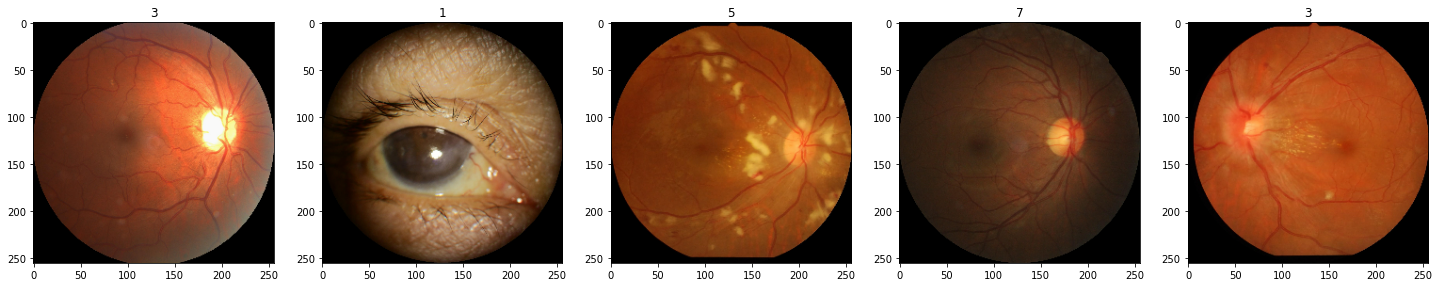

In [431]:
fig, ax = plt.subplots(ncols=5,figsize=(25,25))
for idx, img in enumerate(batch[0][:5]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

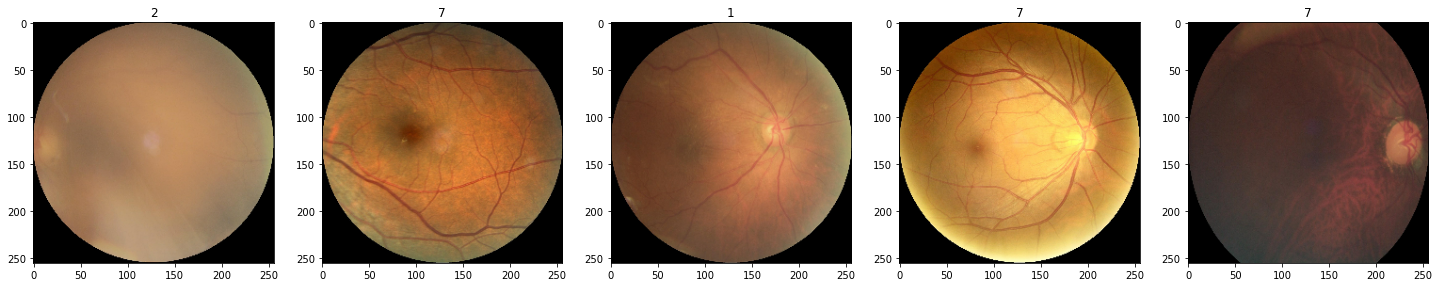

In [432]:
batch = data_iterator.next() # Batch iteration success!
fig, ax = plt.subplots(ncols=5,figsize=(25,25))
for idx, img in enumerate(batch[0][:5]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

At the top of each image, there is a classificaiton number from 0 to 7

### Preprocessing the Data Pipeline
Scaling image values from 0 to 255 to a range of 0 to 1, this will allow for the deep learning model to generalize faster. The data has also already been split into training and testing datasets within the files.

In [433]:
scale = batch[0]/255
print("Min value:",scale.min())
print("Max value:",scale.max())

Min value: 0.0
Max value: 1.0


In [434]:
data = data.map(lambda x,y: (x/255,y)) # Data Transformation x -> images, y -< Target variable

In [435]:
data.as_numpy_iterator().next()[0].max()

1.0

In [436]:
scale_iterator = data.as_numpy_iterator()

In [437]:
batch = scale_iterator.next()

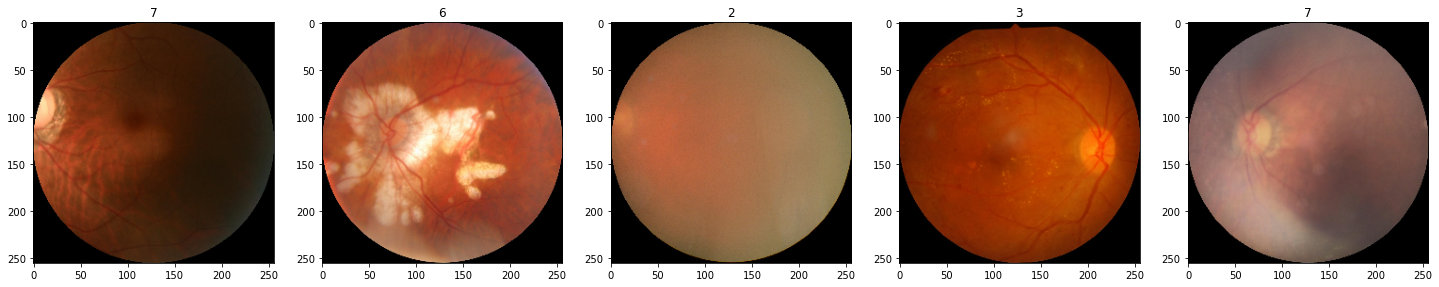

In [438]:
fig, ax = plt.subplots(ncols=5,figsize=(25,25))
for idx, img in enumerate(batch[0][:5]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

In [439]:
# Training, Validation, and Testing datasets
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)
print('Training Size:',train_size)
print('Validation Size:',val_size)
print('Testing Size:',test_size)


Training Size: 67
Validation Size: 19
Testing Size: 9


In [440]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

### Building a Deep Neural Network
Conv2D is the layering tool that will create a Convolutional Neural Network with channels and kernel that will reduce the image's feature dimensions, to allow faster runtime.

In [442]:
from tensorflow.keras.models import Sequential # Model Build API, can also use Functional API
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

# Creating the Model with Relu and Gotta love Layers.
model = Sequential()

model.add(Conv2D(32,(3,3),activation='relu',input_shape=(128,128,3)))
model.add(MaxPooling2D(2,2)) # Cuts the image in half each time.

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))


In [413]:
model.compile(optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [414]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 30, 30, 16)      

### Training the Model

In [416]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [417]:
history = model.fit(train,epochs=20,validation_data=val,callbacks=[tensorboard_callback])

Epoch 1/20
67/67 [==============================] - 62s 905ms/step - loss: 1.6271 - accuracy: 0.4321 - val_loss: 1.5760 - val_accuracy: 0.4449
Epoch 2/20
67/67 [==============================] - 64s 933ms/step - loss: 1.5276 - accuracy: 0.4627 - val_loss: 1.5511 - val_accuracy: 0.4490
Epoch 3/20
67/67 [==============================] - 68s 994ms/step - loss: 1.5051 - accuracy: 0.4569 - val_loss: 1.5115 - val_accuracy: 0.4498
Epoch 4/20
67/67 [==============================] - 61s 894ms/step - loss: 1.4647 - accuracy: 0.4660 - val_loss: 1.4954 - val_accuracy: 0.4482
Epoch 5/20
67/67 [==============================] - 61s 887ms/step - loss: 1.4278 - accuracy: 0.4664 - val_loss: 1.4573 - val_accuracy: 0.4507
Epoch 6/20
67/67 [==============================] - 60s 883ms/step - loss: 1.3825 - accuracy: 0.4802 - val_loss: 1.4560 - val_accuracy: 0.4474
Epoch 7/20
67/67 [==============================] - 61s 893ms/step - loss: 1.3471 - accuracy: 0.4876 - val_loss: 1.4050 - val_accuracy: 0.4663

### Data Modeling Visualization and Evaluation

In [444]:
history.history

{'loss': [1.6271252632141113,
  1.5276046991348267,
  1.5051451921463013,
  1.4647314548492432,
  1.42781400680542,
  1.3824669122695923,
  1.34710693359375,
  1.2940953969955444,
  1.267878770828247,
  1.2458975315093994,
  1.200671672821045,
  1.1669827699661255,
  1.1344883441925049,
  1.0846318006515503,
  1.0393567085266113,
  0.9502626061439514,
  0.9144160747528076,
  0.8792513608932495,
  0.7850882411003113,
  0.7473888993263245],
 'accuracy': [0.432136207818985,
  0.46268656849861145,
  0.4568563401699066,
  0.46595150232315063,
  0.46641790866851807,
  0.48017725348472595,
  0.4876399338245392,
  0.501166045665741,
  0.5030317306518555,
  0.516791045665741,
  0.5284515023231506,
  0.5510727763175964,
  0.5550373196601868,
  0.5739272236824036,
  0.5977145433425903,
  0.636893630027771,
  0.6485540866851807,
  0.6618469953536987,
  0.7024253606796265,
  0.7119869589805603],
 'val_loss': [1.5760191679000854,
  1.551066279411316,
  1.5115394592285156,
  1.495422601699829,
  1.45

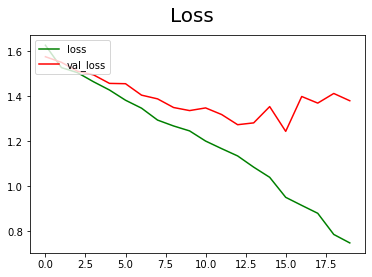

In [445]:
fig= plt.figure()
plt.plot(history.history['loss'],color='green',label='loss')
plt.plot(history.history['val_loss'],color='red',label='val_loss')
fig.suptitle('Loss',fontsize=20)
plt.legend(loc="upper left")
plt.show()

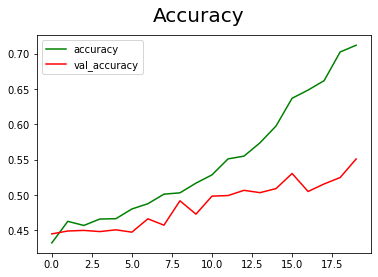

In [446]:
fig= plt.figure()
plt.plot(history.history['accuracy'],color='green',label='accuracy')
plt.plot(history.history['val_accuracy'],color='red',label='val_accuracy')
fig.suptitle('Accuracy',fontsize=20)
plt.legend(loc="upper left")
plt.show()

There appears to be some overfitting happening within the model that stands out at around the 15th epoch. The second CNN model hasn't yet been added yet that analyzes contrast images, which should significantly increase the accuracy while also reducing overfitting. 

### Saving the CNN model into a h5

In [3]:
import h5py
from tensorflow.keras.models import load_model
#model.save(os.path.join("C:\\Users\\David\\OneDrive\\Documents\\GitHub\\Capstone_Project","CNN.h5"))
#new_model = load_model(os.path.join())
#yhatnew = new_model.predict(np.expand_dims(resize/255,0))